### Setup and data import

In [1]:
import pandas as pd
import mols2grid as m2g
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error 
from lightgbm import LGBMRegressor, plot_importance 
import molplotly
import plotly.express as px
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [2]:
sns.set_context('notebook')

In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit import RDLogger
from rdkit.Chem import rdMolDescriptors 
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.SimDivFilters import rdSimDivPickers

In [4]:
df = pd.read_csv('./osc_chemaxondes_elecdata_01092018.csv', comment='#')
# NOTE: Molecule 140 is excluded. It includes an unusual sulphur with two double bonds in aromatic form which causes kekulization error.

In [5]:
df.shape

(170, 29)

In [6]:
# mols2grid is a nice interactive tool to view molecules
m2g.display(df, smiles_col="smiles")

MolGridWidget()

### Clustering using Butina algorithm
This is based on the Rdkit tutorial here:  http://rdkit.blogspot.com/2020/11/sphere-exclusion-clustering-with-rdkit.html

In [7]:
# make molecules out of smiles
mols = [Chem.MolFromSmiles(m) for m in df.smiles]

In [8]:
def cluster(fp_degree, min_distance):
    """Return fingerprints and picked molecules for given
    fp_degree: Morgan Fingerprint degree
    min_distance: minimum distance between cluster centroids
    """
    fps = [rdMolDescriptors.GetMorganFingerprintAsBitVect(m,fp_degree,2048) for m in mols]

    # clustering based on sphere exclusion 
    lp = rdSimDivPickers.LeaderPicker()
    picks = lp.LazyBitVectorPick(fps,len(fps),min_distance)
    return fps, picks

I played with the minimum distance and finger print depth to pick the following values:

In [9]:
fps, picks = cluster(3, 0.8)
len(picks)

16

Let's view the Molecules representing each cluster:

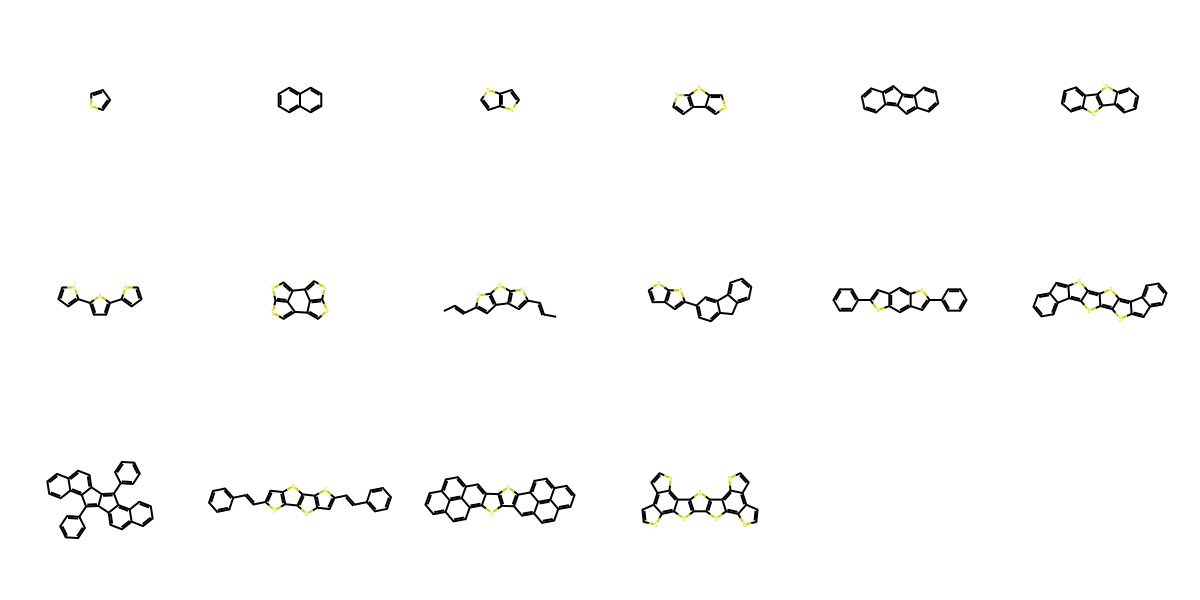

In [10]:

Draw.MolsToGridImage([mols[x] for x in picks],molsPerRow=6)

We can check the similarities between the compounds picked:

In [11]:
from rdkit import DataStructs
pickfps = [fps[x] for x in picks]
nearest = []
simhist = []
for i,fpi in enumerate(pickfps):
    tfps = pickfps[:]
    del tfps[i]
    sims = DataStructs.BulkTanimotoSimilarity(fpi,tfps)
    nearest.append(max(sims))
    simhist.extend(sims)
sorted(nearest,reverse=True)

[0.1951219512195122,
 0.1951219512195122,
 0.19047619047619047,
 0.19047619047619047,
 0.18867924528301888,
 0.18867924528301888,
 0.1875,
 0.1864406779661017,
 0.17857142857142858,
 0.17567567567567569,
 0.17543859649122806,
 0.17543859649122806,
 0.16363636363636364,
 0.15555555555555556,
 0.1509433962264151,
 0.14285714285714285]

Because of the distance cutoff (0.8) we have similarity upto 0.2 only

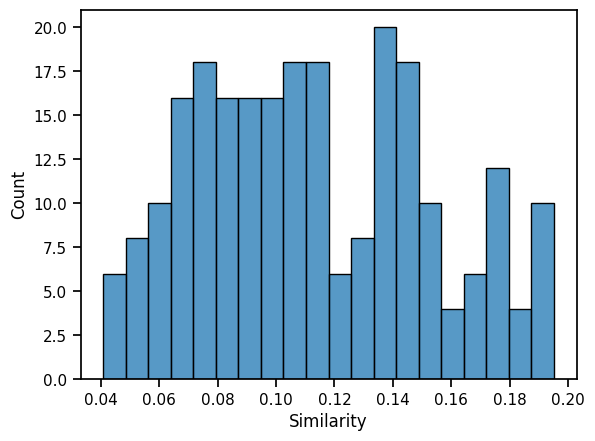

In [12]:
ax = sns.histplot(simhist,bins=20)
ax.set(xlabel='Similarity', ylabel='Count')
plt.show()


Assign molecules to clusters:

In [13]:
def assignPointsToClusters(picks,fps):
    clusters = defaultdict(list) # create a list of tupples as [('cluster_id', [mols idx, ...])]
    for i,idx in enumerate(picks):
        clusters[i].append(idx)
    sims = np.zeros((len(picks),len(fps)))
    for i in range(len(picks)):
        pick = picks[i]
        sims[i,:] = DataStructs.BulkTanimotoSimilarity(fps[pick],fps)
        sims[i,i] = 0
    best = np.argmax(sims,axis=0)
    for i,idx in enumerate(best):
        if i not in picks:
            clusters[idx].append(i)
    return clusters

[Text(0.5, 0, 'Cluster size'), Text(0, 0.5, 'Count')]

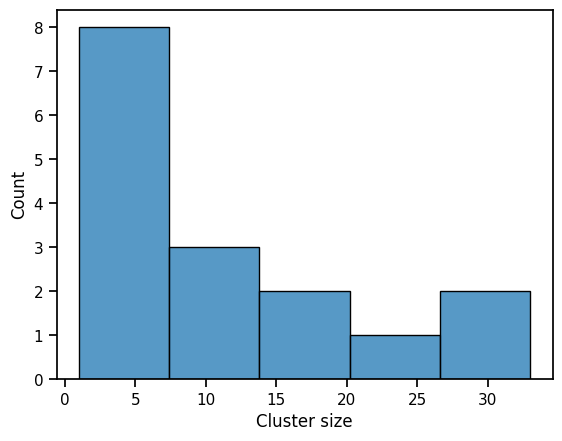

In [14]:
clusters = assignPointsToClusters(picks,fps)
ax = sns.histplot([len(clusters[x]) for x in clusters])
ax.set(xlabel='Cluster size', ylabel='Count')

Let's view one of the clusters (cluster id 3 for example):

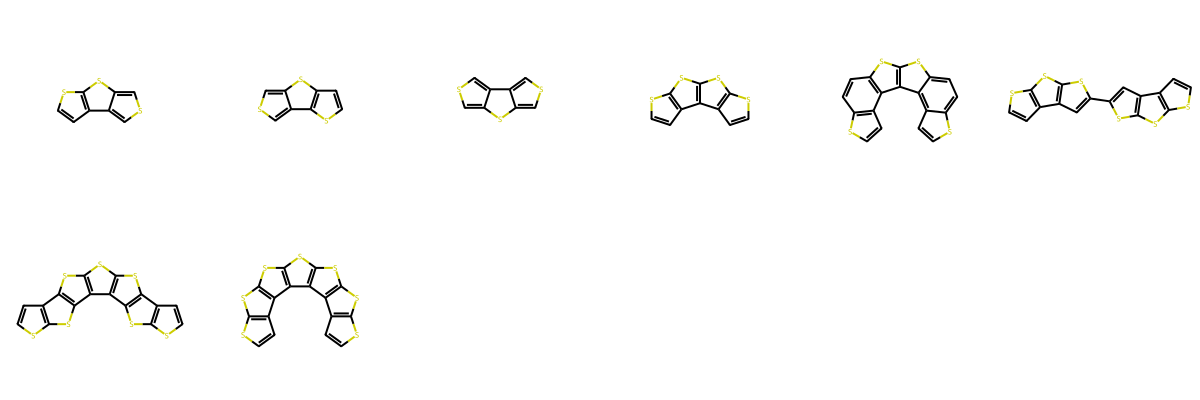

In [15]:
Draw.MolsToGridImage([mols[x] for x in clusters[3]],molsPerRow=6)

In [16]:
#update dataframe with the cluster category for each molecule
df['cluster_id'] = np.nan
for cluster_id, mol_list in clusters.items():
    for mol in mol_list:
        df.loc[mol, 'cluster_id'] = int(cluster_id)

In [17]:
df.cluster_id

0       0.0
1       1.0
2       2.0
3      10.0
4       6.0
       ... 
165     5.0
166     5.0
167    10.0
168     6.0
169     5.0
Name: cluster_id, Length: 170, dtype: float64

In [19]:
fig = px.scatter(df, x = 'avgpol', y ='reorg', color='cluster_id', width=1000, height=600, opacity =0.5,title="Reorganization Energy vs. Average polarization" )
fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

app = molplotly.add_molecules(fig=fig, df=df, smiles_col='smiles', title_col ='CdId')
app.run_server(mode='inline', port=8702)

Dash is running on http://127.0.0.1:8702/



### Clustering with t-sne

In [ ]:
#convert fps to bits:
fps_bits = np.array([list(rdMolDescriptors.GetMorganFingerprintAsBitVect(m,3,2048)) for m in mols])

In [ ]:
# reduce dimension:
pca = PCA(n_components=100)
X_new = pca.fit_transform(fps_bits)
exp = pca.explained_variance_ratio_
[sum(exp[:i]) for i in range(0,len(exp))]

[0,
 0.09013852230745327,
 0.1630969083462984,
 0.22176394612541456,
 0.2762486318337174,
 0.32074509369610266,
 0.3573405285356498,
 0.39070905002524203,
 0.4183186195241059,
 0.4428711663370713,
 0.4655054537251531,
 0.48652743343911903,
 0.5070419563184111,
 0.5269870127158447,
 0.5447223343417813,
 0.5612152682174381,
 0.5774471950571792,
 0.592945524424856,
 0.606969316576826,
 0.6198859991323411,
 0.6322210862432885,
 0.6441318859613944,
 0.6552772418030887,
 0.6659585616267415,
 0.676047352297949,
 0.6855485196137382,
 0.6947752501561794,
 0.7034508431646814,
 0.711827252036244,
 0.7201168929407551,
 0.7279640087619247,
 0.7355271231791063,
 0.7430173486082525,
 0.7502131032563781,
 0.7571017447084354,
 0.763828675943175,
 0.7705069430985702,
 0.7769436431074911,
 0.7828899485807385,
 0.7887962026479828,
 0.7945329646439342,
 0.8000659823159145,
 0.805589240245467,
 0.8109611529669183,
 0.8162029025736833,
 0.8212827478780498,
 0.8261966713813665,
 0.8310053556690915,
 0.8357415

In [ ]:
# perform t-sne
X_embedded = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3).fit_transform(X_new)

In [ ]:
df_tsne = pd.DataFrame(X_embedded, columns=['vec1', 'vec2'])
df_tsne['reorg'] = df['reorg']
df_tsne['cluster_id'] = df['cluster_id']

In [ ]:
fig2 = px.scatter(df_tsne, x = 'vec1', y ='vec2', color='cluster_id', width=1000, height=600, opacity=0.5, 
                  title='Data over the t-SNE 2D embeddings')
fig2.update_traces(marker=dict(size=18),line=dict(width=2,
                                        color='DarkSlateGrey'),
                  selector=dict(mode='markers'))

app = molplotly.add_molecules(fig=fig2, df=df, smiles_col='smiles', title_col ='CdId')
app.run_server(mode='inline', port=8701)

Dash is running on http://127.0.0.1:8701/



With some exceptions, t-sne embedding clusters the compounds similar to the sphere-exclusion based clustering (cluster_id). 